# Import libs

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix

# Read data

In [2]:
df_train = pd.read_csv('data/mnist_train.csv', header=None)
df_test = pd.read_csv('data/mnist_test.csv', header=None)

# Data processing and encoding

In [3]:
X_train = df_train.drop(0, axis=1).to_numpy()
y_train = df_train[0]
X_test = df_test.drop(0, axis=1).to_numpy()
y_test = df_test[0]

del df_train
del df_test

In [4]:
encoder = OneHotEncoder()

In [5]:
X_train = tf.convert_to_tensor(np.array(X_train.tolist()).reshape(-1, 28, 28, 1)/255)
y_train = tf.convert_to_tensor(encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray())
X_test = tf.convert_to_tensor(np.array(X_test.tolist()).reshape(-1, 28, 28, 1)/255)
y_test = tf.convert_to_tensor(encoder.fit_transform(y_test.to_numpy().reshape(-1, 1)).toarray())

# CNN model

In [6]:
cnn_model = tf.keras.Sequential(
    [tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(100, activation=tf.nn.relu),
     tf.keras.layers.Dense(10, activation=tf.nn.softmax)]
)
cnn_model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy', 'AUC'])

In [7]:
with tf.device('GPU'):
    cnn_model.fit(X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
469/469 [==============================] - 6s 13ms/step - loss: 0.0395 - accuracy: 0.9339 - auc: 0.9957
Epoch 2/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0136 - accuracy: 0.9773 - auc: 0.9990 0s - loss: 0.0140 
Epoch 3/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0094 - accuracy: 0.9849 - auc: 0.9993
Epoch 4/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0073 - accuracy: 0.9880 - auc: 0.9995
Epoch 5/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0057 - accuracy: 0.9910 - auc: 0.9997
Epoch 6/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0045 - accuracy: 0.9928 - auc: 0.9997
Epoch 7/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0036 - accuracy: 0.9940 - auc: 0.9999
Epoch 8/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0029 - accuracy: 0

In [8]:
cnn_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0094 - accuracy: 0.9875 - auc: 0.9983


[0.009359901770949364, 0.987500011920929, 0.998284101486206]

# Generate batches of tensor image data augmentation. 

In [9]:
datagen  = image.ImageDataGenerator(rotation_range=[0, 40], 
                                    width_shift_range=(0.01, 1),
                                    height_shift_range=(0.01, 1),
                                    shear_range=(0.01, 1),
                                    zoom_range=(0.01, 1),
                                    horizontal_flip=False)
flow = datagen.flow(X_train, y_train, batch_size=512)

# Make CNN model deeper

In [10]:
cnn_model2 = tf.keras.Sequential(
    [tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(512, activation=tf.nn.relu),
     tf.keras.layers.Dense(100, activation=tf.nn.relu),
     tf.keras.layers.Dense(10, activation=tf.nn.softmax)]
)
cnn_model2.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy', 'AUC'])

In [11]:
cnn_model2.fit(np.vstack((X_train, flow.x)), np.vstack((y_train, flow.y)), epochs=20, batch_size=512)

Epoch 1/20
235/235 [==============================] - 15s 65ms/step - loss: 0.0356 - accuracy: 0.9355 - auc: 0.99631s
Epoch 2/20
235/235 [==============================] - 16s 67ms/step - loss: 0.0071 - accuracy: 0.9880 - auc: 0.9995
Epoch 3/20
235/235 [==============================] - 20s 85ms/step - loss: 0.0047 - accuracy: 0.9920 - auc: 0.9997
Epoch 4/20
235/235 [==============================] - 26s 112ms/step - loss: 0.0032 - accuracy: 0.9946 - auc: 0.9998
Epoch 5/20
235/235 [==============================] - 28s 118ms/step - loss: 0.0022 - accuracy: 0.9963 - auc: 0.9999
Epoch 6/20
235/235 [==============================] - 29s 123ms/step - loss: 0.0015 - accuracy: 0.9976 - auc: 0.9999
Epoch 7/20
235/235 [==============================] - 31s 131ms/step - loss: 0.0014 - accuracy: 0.9976 - auc: 0.9999
Epoch 8/20
235/235 [==============================] - 29s 124ms/step - loss: 0.0011 - accuracy: 0.9981 - auc: 0.9999
Epoch 9/20
235/235 [==============================] - 35s 148ms/s

In [13]:
# cnn_model2.evaluate(flow.x, flow.y)
cnn_model2.evaluate(X_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.0077 - accuracy: 0.9906 - auc: 0.9985


[0.007680173497647047, 0.9905999898910522, 0.9985030889511108]

# Accuracy

In [28]:
acc = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(cnn_model2.predict(X_test), axis=1), labels=np.arange(10))

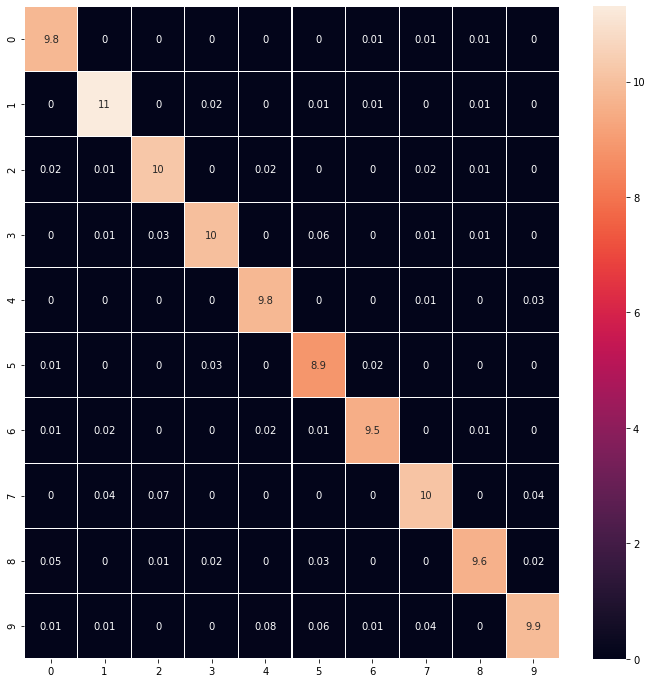

In [38]:
plt.figure(figsize=(12, 12))
sns.heatmap(acc/len(y_test) * 100, annot=True, linewidths=0.1)

# Visualize model

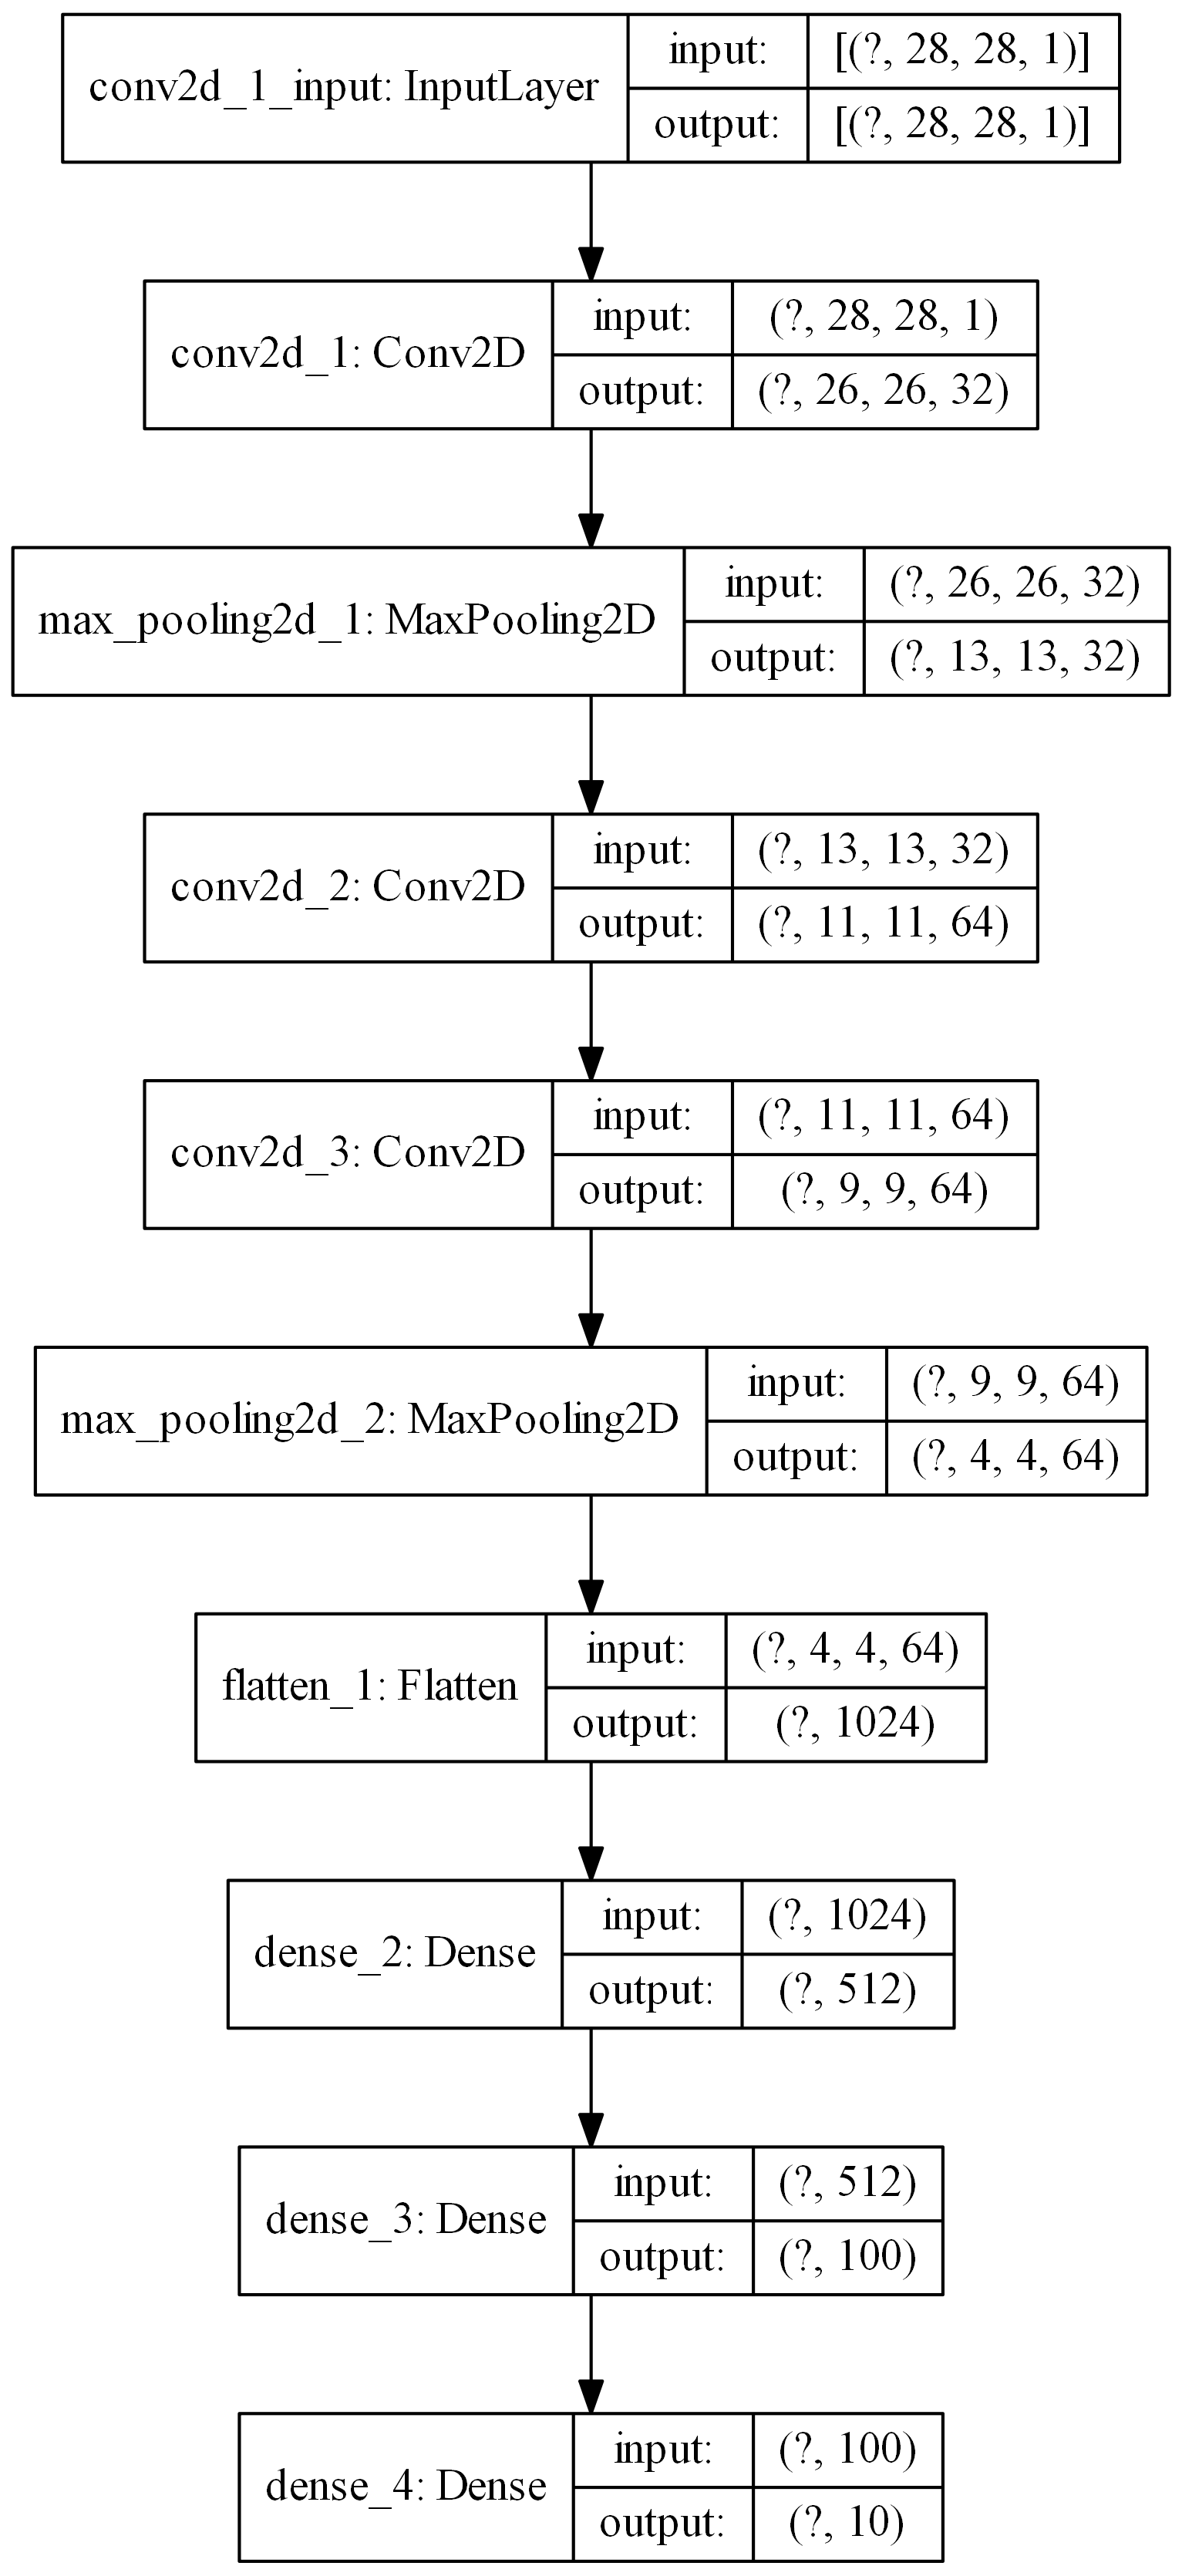

In [41]:
plot_model(cnn_model2, show_shapes=True, expand_nested=True, dpi=300, to_file="img/cnn_model.png")

# Saving model

In [209]:
cnn_model2.save("cnn_model")

INFO:tensorflow:Assets written to: cnn_modal\assets


Saving model in lite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("cnn_model")
tflite_model = converter.convert()
open("cnn_model_android.tflite", "wb").write(tflite_model)